In [4]:
import numpy as np
from nn.nn import NeuralNetwork
from nn.preprocess import sample_seqs, one_hot_encode_seqs
from nn.io import read_fasta_file, read_text_file
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Correctly read in the data
positive_seqs = read_text_file('data/rap1-lieb-positives.txt') # 137
negative_seqs = read_fasta_file('data/yeast-upstream-1k-negative.fa') # 3163

# Explanation of your sampling scheme

We're using upsampling with replacement here because of the severe class imbalance, we don't want to remove a large component of our negative test set (we'd have to remove more than 90% of negative cases). By upsampling we don't delete any data. If we weren't class balancing, we could weight the positive class to be 30x more important, but I think the stochasticity of upsampling w/ replacement is more robust.

In [3]:
# Proper generation of a training set and a validation set.

# Process negatives with sliding window and stepping through each sequence.
processed_negative_sequences = []
window = len(positive_seqs[0])
step = 10
for sequence in negative_seqs:
    for index in range(0, len(sequence) - window, step):
        processed_negative_sequences.append(sequence[index:index + window])

# Encode into positives and negatives
positive_seqs = np.array(one_hot_encode_seqs(positive_seqs))
negative_seqs = np.array(one_hot_encode_seqs(processed_negative_sequences))

pos = [True]*len(positive_seqs)
neg = [False]*len(processed_negative_sequences)

# For the love of God make sure to separate into train/test before upsampling.
X_train_pos, X_val_pos, y_train_pos, y_val_pos = train_test_split(positive_seqs, pos, test_size=0.2)
X_train_neg, X_val_neg, y_train_neg, y_val_neg = train_test_split(negative_seqs, neg, test_size=0.2)

X_train = np.concatenate((X_train_pos, X_train_neg))
X_val = np.concatenate((X_val_pos, X_val_neg))
y_train = np.concatenate((y_train_pos, y_train_neg))
y_val = np.concatenate((y_val_pos, y_val_neg))

# Don't upsample the validation set because we want it to be as close to ground truth as possible.
X_train, y_train = sample_seqs(X_train, y_train)

Epoch 0/30.
Epoch 1/30.
Epoch 2/30.
Epoch 3/30.
Epoch 4/30.
Epoch 5/30.
Epoch 6/30.
Epoch 7/30.
Epoch 8/30.
Epoch 9/30.
Epoch 10/30.
Epoch 11/30.
Epoch 12/30.
Epoch 13/30.
Epoch 14/30.
Epoch 15/30.
Epoch 16/30.
Epoch 17/30.
Epoch 18/30.
Epoch 19/30.
Epoch 20/30.
Epoch 21/30.
Epoch 22/30.
Epoch 23/30.
Epoch 24/30.
Epoch 25/30.
Epoch 26/30.
Epoch 27/30.
Epoch 28/30.
Epoch 29/30.


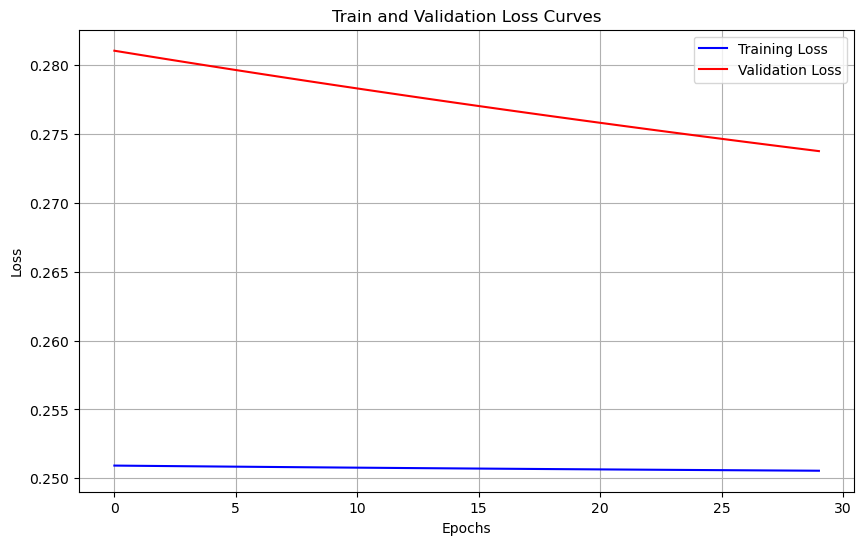

In [ ]:
# Successfully train your classifier

epochs = 30

neural_network = NeuralNetwork(
    [
        {'input_dim': 68, 'output_dim': 64, 'activation': 'relu'},
        {'input_dim': 64, 'output_dim': 32, 'activation': 'sigmoid'},
        {'input_dim': 32, 'output_dim': 16, 'activation': 'relu'},
        {'input_dim': 16, 'output_dim': 8, 'activation': 'sigmoid'},
        {'input_dim': 8, 'output_dim': 4, 'activation': 'relu'},
        {'input_dim': 4, 'output_dim': 2, 'activation': 'sigmoid'},
        {'input_dim': 2, 'output_dim': 1, 'activation': 'sigmoid'},
    ],
    lr = 0.1,
    seed=100,
    batch_size=1000,
    epochs=epochs,
    loss_function="mean_squared_error"
)

train_loss, val_loss = neural_network.fit(X_train, y_train, X_val, y_val)

# Plots of training and validation loss.

plt.figure(figsize=(10, 6))
plt.plot(train_loss, 'b-', label='Training Loss')
plt.plot(val_loss, 'r-', label='Validation Loss')
plt.title("Train and Validation Loss Curves")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
# Reporting validation accuracy of the classifier

y_pred = neural_network.predict(X_val)
predictions = np.where(y_pred > 0.5, np.ceil(y_pred), np.floor(y_pred))
accuracy = np.sum(predictions == y_val) / len(y_val)
print(f"Accuracy: {accuracy}")

Accuracy: 0.0004472700552697997


# Explanation of loss function and hyperparameters

Yeah this one is kind of garbage and there's no saving it. Epochs take significantly longer here, so 10,000 epochs won't be an option. I tried various learning rates and again, a higher one shows SOME decrease in validation loss, but since it is such a low epoch rate it's hard to say. Here the batch size matters a little more, since there are around 500,000 samples after upsampling. Although again there wasn't really a performance change that came with a smaller batch size, nor did it increase performance measurably.

I decided to go with a logarithmic decay instead of linear for...frankly vibes more than anything. Because it's a classifier you do need to end with one node, but nothing requires a decrease until that point.

The accuracy is incrediby low because all the estimations are above 0.5, around 0.52, which means they all round up to positive and, because of the class imbalance, means the model is effectively guessing True always. There is likely some error in the backpropagation step, potentially an activation layer is skipping over each layer.
